In [1]:
import pysm3
import pysm3.units as u
import numpy as np
import numpy.ma as ma
import healpy as hp
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pickle
import qubic
import os
from astropy.io import fits
from qubic import camb_interface as qc
import fgbuster as fgb
from qubicpack.utilities import Qubic_DataDir
from qubic import QubicSkySim as qss
from qubic import fibtools as ft
from qubic import camb_interface as qc
from qubic import SpectroImLib as si
from importlib import reload
from qubic import NamasterLib as nam
from comp_tools import format_alms, same_resolution
from fgbuster import get_instrument, get_sky, get_observation, ilc, basic_comp_sep, harmonic_ilc, weighted_comp_sep, multi_res_comp_sep, harmonic_ilc_alm  # Predefined instrumental and sky-creation configurations
# Imports needed for component separation
from fgbuster import (separation_recipes, xForecast, CMB, Dust, Synchrotron, FreeFree, PowerLaw,  # sky-fitting model
                      basic_comp_sep)
import ComponentSeparation

In [2]:
### Some initializations, to be replaced with specific path, or to modify in bash
os.environ['QUBIC_DATADIR'] = '/home/mathias/Bureau/qubic/qubic'
os.environ['QUBIC_DICT'] = '/home/mathias/Bureau/qubic/qubic/dicts'
global_dir = Qubic_DataDir(datafile='instrument.py', datadir=os.environ['QUBIC_DATADIR'])

### Qubic dictionaries for 150GHz and 220Ghz
config_150, config_220 = 'FI-150', 'FI-220'
dictfilename150 = global_dir + '/doc/FastSimulator/FastSimDemo_{}.dict'.format(config_150)
dictfilename220 = global_dir + '/doc/FastSimulator/FastSimDemo_{}.dict'.format(config_220)
d150, d220 = qubic.qubicdict.qubicDict(), qubic.qubicdict.qubicDict()
d150.read_from_file(dictfilename150)
d220.read_from_file(dictfilename220)
qub_dic = {'150': d150, '220': d220}
center = qubic.equ2gal(d220['RA_center'], d220['DEC_center'])


# Read dictionary chosen
d150['focal_length'] = 0.3
d150['nside'] = 256

#Define the number of reconstruction bands:
nbands = 5
d150['nf_recon'] = nbands
d150['nf_sub'] = nbands

# Read dictionary chosen
d220['focal_length'] = 0.3
d220['nside'] = 256

#Define the number of reconstruction bands:
d220['nf_recon'] = nbands
d220['nf_sub'] = nbands

npix = 12 * d150['nside'] ** 2
Nf = int(d150['nf_sub'])
band = d150['filter_nu'] / 1e9
filter_relative_bandwidth = d150['filter_relative_bandwidth']
npix = 12 * d220['nside'] ** 2
Nf = int(d220['nf_sub'])
band = d220['filter_nu'] / 1e9
filter_relative_bandwidth = d220['filter_relative_bandwidth']
a, nus_edge, nus_in, df, e, Nbbands_in = qubic.compute_freq(band, Nf, filter_relative_bandwidth)

def give_me_freqs_fwhm(dic, Nb) :
    band = dic['filter_nu'] / 1e9
    filter_relative_bandwidth = dic['filter_relative_bandwidth']
    a, nus_edge, nus_in, df, e, Nbbands_in = qubic.compute_freq(band, Nb, filter_relative_bandwidth)
    return nus_in, dic['synthbeam_peak150_fwhm'] * 150 / nus_in


def open_picklefile(directory, name, var) :

    """
    Open a pickle file from saved data
    """

    tab = pickle.load(open(directory + name, 'rb'))
    variable = tab[var]
    return variable

cov150 = open_picklefile('/home/mathias/Bureau/FG-Buster/', 'Coverage_dtheta_15_pointing_3000_256.pkl', 'coverage')


def give_me_mask_apo(okpix = None, lmin = 2, lmax = 512, delta_ell = 16) :
    mask = np.zeros(12 * d150['nside']**2)
    mask[okpix] = 1
    # Namaster object
    Namaster = nam.Namaster(mask, lmin=2, lmax=512, delta_ell=16)
    apo = Namaster.mask_apo
    return apo

# Define okpix
okpix_inside = (cov150 > (0.4*np.max(cov150)))
okpix = (cov150 > (0.1*np.max(cov150)))

apo = give_me_mask_apo(okpix = okpix)

okpix_fullsky = np.ones(12*d150['nside']**2)

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:907: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_over(newcm(1.0))
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:908: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  newcm.set_under(bgcolor)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/projaxes.py:909: MatplotlibDeprecationWarning: You are modifyin

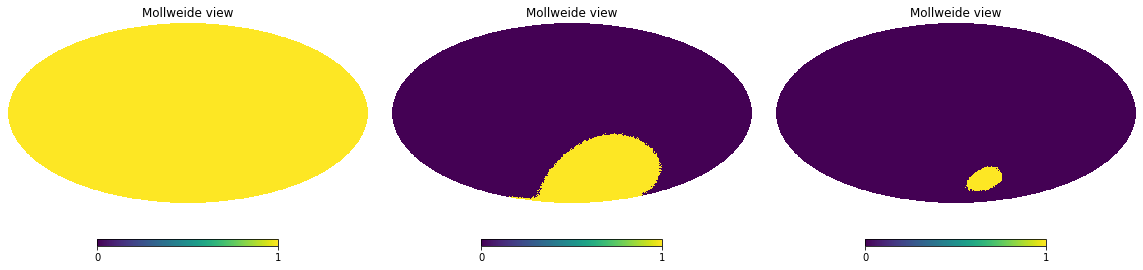

In [3]:
okpix_fullsky = np.ones(12*d150['nside']**2)
okpix_fullsky = okpix_fullsky != 0
okpix = cov150 != 0
okpix_inside = (cov150 > (0.5*np.max(cov150)))
nbands = 5
d150['nf_recon'] = nbands
d150['nf_sub'] = 4*nbands
d220['nf_recon'] = nbands
d220['nf_sub'] = 4*nbands

plt.figure(figsize = (16, 10))
hp.mollview(okpix_fullsky, sub = (1, 3, 1), min = 0, max = 1)
hp.mollview(okpix, sub = (1, 3, 2), min = 0, max = 1)
hp.mollview(okpix_inside, sub = (1, 3, 3), min = 0, max = 1)
plt.show()

In [7]:
reload(ComponentSeparation)
N = 2
method = 'alms'

beta_fs_noapo_150 = np.zeros(N)

for i in range(N) :

    r_alms_fs_noapo_150, _, _ = ComponentSeparation.Apply(d150).do_comparison_pixels_alms(d150, 
                                                                   nbands, 
                                                                   3, 
                                                                   okpix_fullsky, 
                                                                   seed = None,
                                                                   map1 = None, 
                                                                   map_noise = None, 
                                                                   do_apo = False, 
                                                                   noiseless = False, 
                                                                   method = method, 
                                                                   dust_only = False)
    
    beta_fs_noapo_150[i] = r_alms_fs_noapo_150.x[0]
    
print(beta_fs_noapo_150)
print(np.mean(beta_fs_noapo_150))
print(np.std(beta_fs_noapo_150))

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/fRrIukhy8A
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/GWlOmkbwpp
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started
[1.55638334 1.55395231]
1.555167824832346
0.0012155167034838543


In [14]:
reload(ComponentSeparation)
N = 5
method = 'pixels'

beta_pixels_fs_noapo_150 = np.zeros(N)
beta_pixels_fs_noapo_220 = np.zeros(N)
beta_pixels_qs_noapo_150 = np.zeros(N)
beta_pixels_qs_noapo_220 = np.zeros(N)
beta_pixels_qs_apo_150 = np.zeros(N)
beta_pixels_qs_apo_220 = np.zeros(N)

for i in range(N) :

    r_pixels_fs_noapo_150, _, _ = ComponentSeparation.Apply(d150).do_comparison_pixels_alms(d150, 
                                                                   nbands, 
                                                                   3, 
                                                                   okpix_fullsky, 
                                                                   seed = i+1,
                                                                   map1 = None, 
                                                                   map_noise = None, 
                                                                   do_apo = False, 
                                                                   noiseless = False, 
                                                                   method = method, 
                                                                   dust_only = False)
    
    r_pixels_fs_noapo_220, _, _ = ComponentSeparation.Apply(d220).do_comparison_pixels_alms(d220, 
                                                                   nbands, 
                                                                   3, 
                                                                   okpix_fullsky, 
                                                                   seed = i+1,
                                                                   map1 = None, 
                                                                   map_noise = None, 
                                                                   do_apo = False, 
                                                                   noiseless = False, 
                                                                   method = method, 
                                                                   dust_only = False)
    
    r_pixels_qs_noapo_150, _, _ = ComponentSeparation.Apply(d150).do_comparison_pixels_alms(d150, 
                                                                   nbands, 
                                                                   3, 
                                                                   okpix, 
                                                                   seed = i+1,
                                                                   map1 = None, 
                                                                   map_noise = None, 
                                                                   do_apo = False, 
                                                                   noiseless = False, 
                                                                   method = method, 
                                                                   dust_only = False)
    
    r_pixels_qs_noapo_220, _, _ = ComponentSeparation.Apply(d220).do_comparison_pixels_alms(d220, 
                                                                   nbands, 
                                                                   3, 
                                                                   okpix, 
                                                                   seed = i+1,
                                                                   map1 = None, 
                                                                   map_noise = None, 
                                                                   do_apo = False, 
                                                                   noiseless = False, 
                                                                   method = method, 
                                                                   dust_only = False)
    
    r_pixels_qs_apo_150, _, _ = ComponentSeparation.Apply(d150).do_comparison_pixels_alms(d150, 
                                                                   nbands, 
                                                                   3, 
                                                                   okpix, 
                                                                   seed = i+1,
                                                                   map1 = None, 
                                                                   map_noise = None, 
                                                                   do_apo = True, 
                                                                   noiseless = False, 
                                                                   method = method, 
                                                                   dust_only = False)
    
    r_pixels_qs_apo_220, _, _ = ComponentSeparation.Apply(d150).do_comparison_pixels_alms(d220, 
                                                                   nbands, 
                                                                   3, 
                                                                   okpix, 
                                                                   seed = i+1,
                                                                   map1 = None, 
                                                                   map_noise = None, 
                                                                   do_apo = True, 
                                                                   noiseless = False, 
                                                                   method = method, 
                                                                   dust_only = False)
    
    beta_pixels_fs_noapo_150 = r_pixels_fs_noapo_150.x[0]
    beta_pixels_fs_noapo_220 = r_pixels_fs_noapo_220.x[0]
    beta_pixels_qs_noapo_150 = r_pixels_qs_noapo_150.x[0]
    beta_pixels_qs_noapo_220 = r_pixels_qs_noapo_220.x[0]
    beta_pixels_qs_apo_150 = r_pixels_qs_apo_150.x[0]
    beta_pixels_qs_apo_220 = r_pixels_qs_apo_220.x[0]

/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/AkP2nWEoxI
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/i2c26R2bc1
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/uYHgTGsLHU
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/JcaZbeE1hL
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/o3s1CFKAHX
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/vY6gQkuvue
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/HLN4ilU9pa
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/iA2wN7vcyG
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/yhlu24CEbT
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/Ntw5u1HSRS
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/u6rBQ2lDjW
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/kjLi12Kyr3
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/V0R0t1s6b0
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/U6dqy4F1LA
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/KLRHrfZEKX
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/wRXh8oG41k
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/aqdWeOAaeE
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/VKGr2GIvxX
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/dycJMCU54I
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/nzUzpEIKp0
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/IaYtl6Tqpp
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/MYoemk4zyh
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/PMzbYOLeYe
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/uvW0ihACIe
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/7KIC5gSPx2
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/FhldWCSVti
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/9YpMHfGwuC
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/HsYyyUnDfX
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/1NUOfpDjkN
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI150_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/healpy/fitsfunc.py:187: FutureWarning: The default dtype of write_map() will change in a future version: explicitly set the dtype if it is important to you
  category=FutureWarning)
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:37: UserWarning: Access data from /tmp/gk7yzCNFT4
  warnings.warn(f"Access data from {full_path}")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_t_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/utils/data.py:42: UserWarning: Retrieve data for pysm_2/dust_q_new.fits (if not cached already)
  warnings.warn(f"Retrieve data for {filename} (if not cached already)")
/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/pysm3/uti

<_io.BufferedReader name='/home/mathias/miniconda3/envs/qubic_env/lib/python3.7/site-packages/qubic/data/FastSimulator_version01/DataFastSimulator_FI220_nfsub_5.pkl'>


/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:648: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.frequency = freqs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:649: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.fwhm = fwhmdegs
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:653: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.depth_i = give_me_rms_I(N[:, :, okpix], self.nside)
/home/mathias/Bureau/FG-Buster/ComponentSeparation.py:654: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  ins.de

Minimization started


In [19]:
mean_beta_pixels_fs_noapo_150 = np.mean(beta_pixels_fs_noapo_150)
mean_beta_pixels_fs_noapo_220 = np.mean(beta_pixels_fs_noapo_220)
mean_beta_pixels_qs_noapo_150 = np.mean(beta_pixels_qs_noapo_150)
mean_beta_pixels_qs_noapo_220 = np.mean(beta_pixels_qs_noapo_220)
mean_beta_pixels_qs_apo_150 = np.mean(beta_pixels_qs_apo_150)
mean_beta_pixels_qs_apo_220 = np.mean(beta_pixels_qs_apo_220)

mean_beta_alms_fs_noapo_150 = np.mean(beta_alms_fs_noapo_150)
mean_beta_alms_fs_noapo_220 = np.mean(beta_alms_fs_noapo_220)
mean_beta_alms_qs_noapo_150 = np.mean(beta_alms_qs_noapo_150)
mean_beta_alms_qs_noapo_220 = np.mean(beta_alms_qs_noapo_220)
mean_beta_alms_qs_apo_150 = np.mean(beta_alms_qs_apo_150)
mean_beta_alms_qs_apo_220 = np.mean(beta_alms_qs_apo_220)

std_beta_pixels_fs_noapo_150 = np.std(beta_pixels_fs_noapo_150)
std_beta_pixels_fs_noapo_220 = np.std(beta_pixels_fs_noapo_220)
std_beta_pixels_qs_noapo_150 = np.std(beta_pixels_qs_noapo_150)
std_beta_pixels_qs_noapo_220 = np.std(beta_pixels_qs_noapo_220)
std_beta_pixels_qs_apo_150 = np.std(beta_pixels_qs_apo_150)
std_beta_pixels_qs_apo_220 = np.std(beta_pixels_qs_apo_220)

std_beta_alms_fs_noapo_150 = np.std(beta_alms_fs_noapo_150)
std_beta_alms_fs_noapo_220 = np.std(beta_alms_fs_noapo_220)
std_beta_alms_qs_noapo_150 = np.std(beta_alms_qs_noapo_150)
std_beta_alms_qs_noapo_220 = np.std(beta_alms_qs_noapo_220)
std_beta_alms_qs_apo_150 = np.std(beta_alms_qs_apo_150)
std_beta_alms_qs_apo_220 = np.std(beta_alms_qs_apo_220)

In [21]:
beta_pixels_fs_noapo_150

1.5391924590325747

In [20]:
print("For full sky without apo : ")
print("\n    Alms : ")
print("\n        150 GHz : {:.5f} +/- {:.12f}".format(mean_beta_alms_fs_noapo_150, std_beta_alms_fs_noapo_150))
print("\n        220 GHz : {:.5f} +/- {:.12f}".format(mean_beta_alms_fs_noapo_220, std_beta_alms_fs_noapo_220))
print("\n    Pixels : ")
print("\n        150 GHz : {:.5f} +/- {:.12f}".format(mean_beta_pixels_fs_noapo_150, std_beta_pixels_fs_noapo_150))
print("\n        220 GHz : {:.5f} +/- {:.12f}".format(mean_beta_pixels_fs_noapo_220, std_beta_pixels_fs_noapo_220))

print("\n For QUBIC sky without apo : ")
print("\n    Alms : ")
print("\n        150 GHz : {:.5f} +/- {:.12f}".format(mean_beta_alms_qs_noapo_150, std_beta_alms_qs_noapo_150))
print("\n        220 GHz : {:.5f} +/- {:.12f}".format(mean_beta_alms_qs_noapo_220, std_beta_alms_qs_noapo_220))
print("\n    Pixels : ")
print("\n        150 GHz : {:.5f} +/- {:.12f}".format(mean_beta_pixels_qs_noapo_150, std_beta_pixels_qs_noapo_150))
print("\n        220 GHz : {:.5f} +/- {:.12f}".format(mean_beta_pixels_qs_noapo_220, std_beta_pixels_qs_noapo_220))

print("\n For QUBIC sky with apo : ")
print("\n    Alms : ")
print("\n        150 GHz : {:.5f} +/- {:.12f}".format(mean_beta_alms_qs_apo_150, std_beta_alms_qs_apo_150))
print("\n        220 GHz : {:.5f} +/- {:.12f}".format(mean_beta_alms_qs_apo_220, std_beta_alms_qs_apo_220))
print("\n    Pixels : ")
print("\n        150 GHz : {:.5f} +/- {:.12f}".format(mean_beta_pixels_qs_apo_150, std_beta_pixels_qs_apo_150))
print("\n        220 GHz : {:.5f} +/- {:.12f}".format(mean_beta_pixels_qs_apo_220, std_beta_pixels_qs_apo_220))

For full sky without apo : 

    Alms : 

        150 GHz : 1.55292 +/- 0.000000000000

        220 GHz : 1.54010 +/- 0.000000000000

    Pixels : 

        150 GHz : 1.53919 +/- 0.000000000000

        220 GHz : 1.53977 +/- 0.000000000000

 For QUBIC sky without apo : 

    Alms : 

        150 GHz : 1.51156 +/- 0.000000000000

        220 GHz : 1.54722 +/- 0.000000000000

    Pixels : 

        150 GHz : 1.33370 +/- 0.000000000000

        220 GHz : 1.54165 +/- 0.000000000000

 For QUBIC sky with apo : 

    Alms : 

        150 GHz : 2.01424 +/- 0.000000000000

        220 GHz : 1.55129 +/- 0.000000000000

    Pixels : 

        150 GHz : 1.53992 +/- 0.000000000000

        220 GHz : 1.54071 +/- 0.000000000000
